In [1]:
# ===============================================================
#  HOMOCHIRALITY STEERING EXPERIMENT (CLEAN REWRITE)
#  Uses: QuTiP + CVXPY + SciPy logm
#  Author: Turbasu Chatterjee
# ===============================================================

import numpy as np
import qutip as qt
import cvxpy as cp
from scipy.linalg import logm, expm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
from scipy.optimize import nnls

In [2]:
# ===============================================================
# Hamiltonian + utilities
# ===============================================================
def generate_hamiltonians(a_values, b_values):
    sz, sx = qt.sigmaz(), qt.sigmax()
    return {(a, b): 0.5 * a * sz + 0.5 * b * sx for a in a_values for b in b_values}

def time_evolve_state(H, psi0, tlist):
    return qt.sesolve(H, psi0, tlist).states

In [3]:
# ===============================================================
# Choi helpers
# ===============================================================

def _J_block(J, i, j):
    r = slice(2 * i, 2 * (i + 1))
    c = slice(2 * j, 2 * (j + 1))
    return J[r, c]

def _phi_of_rho_from_choi(J, rho):
    """Φ(ρ) = Σ_{i,j} ρ_{j,i} * J_{i,j} (qubit)."""
    out = 0
    for i in range(2):
        for j in range(2):
            out += rho[j, i] * _J_block(J, i, j)
    return out

def _tp_constraints(J):
    """Trace preservation Tr_Y J = I_X for qubits, plus CP (J ⪰ 0)."""
    cons = [J >> 0]
    for i in range(2):
        for j in range(2):
            cons.append(cp.trace(_J_block(J, i, j)) == (1.0 if i == j else 0.0))
    return cons

def _covariance_constraints(J, H):
    """[H ⊗ I - I ⊗ Hᵗ, J] = 0 (linear)."""
    I2 = np.eye(2)
    Hm = H if isinstance(H, np.ndarray) else H.full()
    G = np.kron(Hm, I2) - np.kron(I2, Hm.T)
    return [G @ J - J @ G == 0]

def kraus_from_choi(J_opt):
    """Choi → Kraus (qubit)."""
    J_q = qt.Qobj(J_opt, dims=[[2, 2], [2, 2]])
    evals, evecs = J_q.eigenstates()
    K_list = []
    for lam, vec in zip(evals, evecs):
        if np.real(lam) > 1e-10:
            K = np.sqrt(lam) * vec.full().reshape(2, 2, order="F")
            K_list.append(qt.Qobj(K))
    return K_list

In [4]:
# ===============================================================
# Local steering SDP (per step)
# ===============================================================

def fidelity_sdp_step(
    rho_qobj,
    sigma_qobj,
    H_qobj,
    *,
    impose_covariance=True,
    impose_passivity=False,
    step_size=0.1,
    eta=1.0,
    p_min=None,
    verbose=False,
):
    """
    Local endpoint-only steering:
      maximize sqrtF(Φ(ρ), σ)
      s.t. J CPTP, optional covariance/passivity,
           step locality ||Φ(ρ)-ρ||_F ≤ eta*step_size,
           optional population floor Tr[|e><e| Φ(ρ)] ≥ p_min.
    """
    rho = rho_qobj.full()
    sigma = sigma_qobj.full()
    H = H_qobj.full()

    J = cp.Variable((4, 4), complex=True)
    W = cp.Variable((2, 2), complex=True)
    t = cp.Variable()

    constraints = _tp_constraints(J)
    if impose_covariance:
        constraints += _covariance_constraints(J, H)

    Phi_rho = _phi_of_rho_from_choi(J, rho)
    constraints += [Phi_rho >> 0, cp.trace(Phi_rho) == 1]

    # Locality proxy (keeps logm well-behaved)
    constraints += [cp.norm(Phi_rho - rho, "fro") <= eta * step_size]

    # Optional passivity
    if impose_passivity:
        lhs = cp.real(cp.trace(H @ Phi_rho))
        rhs = float(np.trace(H @ rho))
        constraints += [lhs <= rhs + 1e-12]

    # Optional per-step excited-population floor
    if p_min is not None:
        Pe = np.array([[0, 0], [0, 1]], dtype=complex)
        constraints += [cp.real(cp.trace(cp.kron(Pe, rho.T) @ J)) >= p_min]

    # Uhlmann fidelity block
    block = cp.bmat([[Phi_rho, W], [W.H, sigma]])
    constraints += [block >> 0, cp.real(cp.trace(W)) >= t]

    prob = cp.Problem(cp.Maximize(t), constraints)
    prob.solve(
        solver=cp.SCS,
        verbose=verbose,
        eps_abs=1e-4,
        eps_rel=1e-4,
        max_iters=30000,
    )

    sqrtF = float(prob.value) if prob.value is not None else np.nan
    F = sqrtF**2 if np.isfinite(sqrtF) else np.nan

    return dict(
        status=prob.status,
        sqrtF=sqrtF,
        fidelity=F,
        J=None if J.value is None else J.value.copy(),
        Phi_rho=None if Phi_rho.value is None else Phi_rho.value.copy(),
    )


In [5]:
# ===============================================================
# Kraus & GKSL extraction (from known H)
# ===============================================================

def gksl_from_kraus_and_H(kraus_ops, H, dt=1.0, eps=1e-10):
    """
    Given Kraus ops and known Hamiltonian H:
      L_total = (log Φ)/dt
      L_H     = -i(H ⊗ I - I ⊗ Hᵗ)
      L_D     = L_total - L_H
    """
    d = H.shape[0] if isinstance(H, np.ndarray) else H.shape[0]
    Phi = np.zeros((d * d, d * d), dtype=complex)
    for K in kraus_ops:
        Kmat = K.full() if isinstance(K, qt.Qobj) else K
        Phi += np.kron(Kmat, Kmat.conj())

    Phi_reg = (1 - eps) * Phi + eps * np.eye(d * d)
    L_total = (1.0 / dt) * logm(Phi_reg)

    Hm = H.full() if isinstance(H, qt.Qobj) else H
    I = np.eye(d)
    L_H = -1j * (np.kron(Hm, I) - np.kron(I, Hm.T))
    L_D = L_total - L_H
    return L_total, L_H, L_D

# Dissipator decomposition (σ-, σ+, σz dephasing)
def _diss_basis_qubit():
    sz, sp, sm = qt.sigmaz(), qt.sigmap(), qt.sigmam()
    Bd = qt.liouvillian(0 * sz, [sm]).full()
    Bu = qt.liouvillian(0 * sz, [sp]).full()
    Bp = qt.liouvillian(0 * sz, [sz]).full()
    return Bd, Bu, Bp

def decompose_dissipator_nnls_energy(L_D, H):
    Bd, Bu, Bp = diss_basis_in_energy(H)
    A = np.column_stack([Bd.reshape(-1,1), Bu.reshape(-1,1), Bp.reshape(-1,1)]).real
    b = np.real(L_D.reshape(-1,1))
    x, _ = nnls(A, b.ravel())
    g_down, g_up, g_phi = x
    p_e_inf = g_up/(g_up+g_down) if (g_up+g_down)>1e-15 else 0.0
    return dict(gamma_down=g_down, gamma_up=g_up, gamma_phi=g_phi, p_e_inf=p_e_inf)

def build_pure_pumping_generator_energy(L_H, L_D, H, force_pure_pumping=True):
    if not force_pure_pumping:
        return qt.Qobj(L_H + L_D, dims=[[2,2],[2,2]])
    Bd, Bu, Bp = diss_basis_in_energy(H)
    A = np.column_stack([Bd.reshape(-1,1), Bu.reshape(-1,1), Bp.reshape(-1,1)]).real
    b = np.real(L_D.reshape(-1,1))
    x, _ = nnls(A, b.ravel())
    g_down, g_up, g_phi = x
    g_down = 0.0  # enforce pure pumping toward |excited⟩
    L_D_pure = g_up*Bu + g_phi*Bp
    return qt.Qobj(L_H + L_D_pure, dims=[[2,2],[2,2]])

def _unitary_to_energy_basis(H):
    # columns are eigenvectors; evecs[0]=|g>, evecs[1]=|e>
    evals, evecs = H.eigenstates(sort='low')
    U = qt.Qobj(np.column_stack([evecs[0].full(), evecs[1].full()]))
    return U

def _rotate_op_to_lab(U, O_energy):
    # O_lab = U O_energy U^\dagger
    return U * O_energy * U.dag()

def diss_basis_in_energy(H):
    """Build Bd, Bu, Bp in the ENERGY basis of H, then rotate to lab frame and return Liouvillian matrices."""
    U = _unitary_to_energy_basis(H)
    # energy-basis jump ops (|g><e|, |e><g|, σz_energy)
    g = qt.basis(2,0)
    e = qt.basis(2,1)
    sm_E = g*e.dag()                 # |g><e|
    sp_E = e*g.dag()                 # |e><g|
    sz_E = qt.sigmaz()               # diag(+1,-1) in {g,e} order

    # rotate to lab (computational) frame
    sm = _rotate_op_to_lab(U, sm_E)
    sp = _rotate_op_to_lab(U, sp_E)
    sz = _rotate_op_to_lab(U, sz_E)

    # Liouvillian basis in lab frame
    Bd = qt.liouvillian(0*sz, [sm]).full()   # decay (e→g)
    Bu = qt.liouvillian(0*sz, [sp]).full()   # pumping (g→e)
    Bp = qt.liouvillian(0*sz, [sz]).full()   # dephasing in energy basis
    return Bd, Bu, Bp



In [6]:
# ===============================================================
# Diagnostics
# ===============================================================

def choi_from_super(Phi):
    """Choi(J) from superoperator Phi (qubit, F-order)."""
    J = np.zeros((4, 4), dtype=complex)
    for i in range(2):
        for j in range(2):
            eij = np.zeros((2, 2), complex)
            eij[i, j] = 1.0
            vec = eij.reshape(-1, 1, order="F")
            out = Phi @ vec
            Φ_eij = out.reshape(2, 2, order="F")
            r = slice(2 * i, 2 * (i + 1))
            c = slice(2 * j, 2 * (j + 1))
            J[r, c] = Φ_eij
    return J

def verify_L_strict(L_qobj, t=0.1, verbose=True):
    """TP (left/right), CP of e^{tL} via Choi ⪰ 0."""
    Lm = L_qobj.full()
    I2 = np.eye(2)
    vI = I2.reshape(-1, 1, order="F")
    tp_left = np.linalg.norm(vI.conj().T @ Lm)   # <I|L
    tp_right = np.linalg.norm(Lm @ vI)           # L|I>
    if verbose:
        print(f"TP left  = {tp_left:.3e}, TP right = {tp_right:.3e}")
    Phi_t = expm(Lm * t)
    J = choi_from_super(Phi_t)
    eigs = np.linalg.eigvalsh(0.5 * (J + J.conj().T))
    print(f"Min eigenvalue of Choi(e^(tL)): {np.min(eigs):.3e}")
    return tp_left, tp_right, eigs


In [7]:
# ===============================================================
# RUN SECTION  (TUNABLE PARAMETERS)
# ===============================================================


# ----- Tunables -----
a_vals = np.linspace(-2, 2, 5)
b_vals = np.linspace(-1, 1, 5)

# choose H = (a/2) σz + (b/2) σx
key = (-2.0, -1.0)  # TIP: set b=0.0 to kill tunneling if you want monotone pumping
hams = generate_hamiltonians(a_vals, b_vals)
H = hams[key]

# ----- Evolve a superposition under the fitted generator -----
psi_super = (qt.basis(2, 0) + qt.basis(2, 1)).unit()
rho_super0 = qt.ket2dm(psi_super)

# time grid
tlist = np.linspace(0, 30, 100)
dt = tlist[1] - tlist[0]

# eigenstates + initial/target
evals, evecs = H.eigenstates(sort="low")
ground, excited = evecs[0], evecs[1]
rho0 = qt.ket2dm(ground)
sigma_target = qt.ket2dm(excited)

# unitary pre-evolution states
states_t = time_evolve_state(H, ground, tlist)

# SDP controls
impose_covariance = True
impose_passivity = False
eta = 1.0           # step locality (bigger → stronger nudges)
p_min = 0.95        # per-step excited-pop floor; set None to disable

# ----- Solve local SDPs with progress bar -----
print("Solving local steering SDPs...")
sdp_results = []
for psi_t in tqdm(states_t, desc="SDP steps", unit="SDP"):
    rho_t = qt.ket2dm(psi_t)
    out = fidelity_sdp_step(
        rho_t,
        sigma_target,
        H,
        impose_covariance=impose_covariance,
        impose_passivity=impose_passivity,
        step_size=dt,
        eta=eta,
        p_min=p_min,
        verbose=False,
    )
    sdp_results.append(out)

# ----- Extract one representative generator (you can loop over many if you like) -----
idx = 10
out = sdp_results[idx]
kraus_ops = kraus_from_choi(out["J"])
L_total, L_H, L_D = gksl_from_kraus_and_H(kraus_ops, H, dt=dt)

rates = decompose_dissipator_nnls_energy(L_D, H)
print("Energy-basis rates:", rates)

force_pure_pumping = True
L_total_q = build_pure_pumping_generator_energy(L_H, L_D, H, force_pure_pumping)

# Evolve and MEASURE with Pe_exc:
Pe_exc = sigma_target
p_excited = []
for t in tlist:
    Phi_t = expm(L_total_q.full() * t)
    rho_vec = qt.operator_to_vector(rho_super0).full()
    rho_t = qt.Qobj((Phi_t @ rho_vec).reshape((2,2), order='F'))
    p_excited.append(qt.expect(Pe_exc, rho_t))

# dissipative vs Hamiltonian sizes (just a feel)
L_sym = 0.5 * (L_total + L_total.conj().T)
L_anti = 0.5 * (L_total - L_total.conj().T)
print("||L_sym|| (dissipative): ", np.linalg.norm(L_sym))
print("||L_anti|| (Hamiltonian):", np.linalg.norm(L_anti))

# rates + steady-pop prediction
rates = decompose_dissipator_nnls_energy(L_D, H)
print("Estimated rates (from L_D):", rates)

# build total generator; set force_pure_pumping=True to zero γ_down
force_pure_pumping = True
L_total_q = build_pure_pumping_generator_energy(L_H, L_D, H, force_pure_pumping=force_pure_pumping)

# verify generator
_ = verify_L_strict(L_total_q, t=dt, verbose=True)



rho_list = []
p_excited = []
purity = []

for t in tlist:
    Phi_t = expm(L_total_q.full() * t)
    rho_vec = qt.operator_to_vector(rho_super0).full()
    rho_t_vec = Phi_t @ rho_vec
    rho_t = qt.Qobj(rho_t_vec.reshape((2, 2), order="F"))
    rho_list.append(rho_t)
    Pe_exc = sigma_target          # = excited * excited.dag()
    p_excited = [qt.expect(Pe_exc, rho) for rho in rho_list]
    purity.append(np.real((rho_t * rho_t).tr()))

print("Min excited population over trajectory:", float(np.min(p_excited)))



Solving local steering SDPs...


SDP steps:   0%|          | 0/100 [00:00<?, ?SDP/s]

/Users/tchatterjee/anaconda3/envs/pmp/lib/python3.13/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Energy-basis rates: {'gamma_down': np.float64(4.188988781950228), 'gamma_up': np.float64(0.8969735989314894), 'gamma_phi': np.float64(10.349955973176026), 'p_e_inf': np.float64(0.17636260981859395)}
||L_sym|| (dissipative):  33.67885367652109
||L_anti|| (Hamiltonian): 11.636754469078143
Estimated rates (from L_D): {'gamma_down': np.float64(4.188988781950228), 'gamma_up': np.float64(0.8969735989314894), 'gamma_phi': np.float64(10.349955973176026), 'p_e_inf': np.float64(0.17636260981859395)}
TP left  = 1.256e-15, TP right = 1.269e+00
Min eigenvalue of Choi(e^(tL)): -2.882e-17
Min excited population over trajectory: 0.27639320225002106


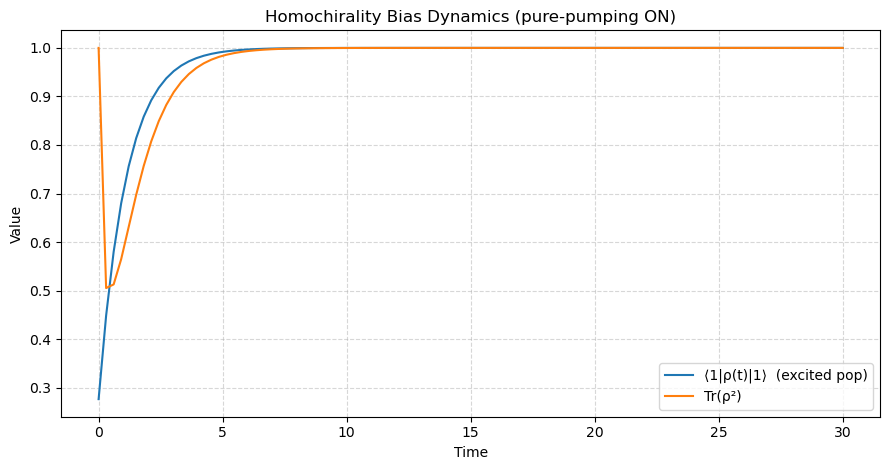

In [8]:
plt.figure(figsize=(9, 4.8))
plt.plot(tlist, p_excited, label="⟨1|ρ(t)|1⟩  (excited pop)")
plt.plot(tlist, purity, label="Tr(ρ²)")
ttl = "Homochirality Bias Dynamics (pure-pumping ON)" if force_pure_pumping else "Homochirality Bias Dynamics"
plt.title(ttl)
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True, ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
vec = qt.operator_to_vector
unvec = lambda v: qt.Qobj(v.reshape((2,2), order='F'))
rho0_vec = vec(rho_super0).full()
drho_dt_vec = L_total_q.full() @ rho0_vec
drho_dt = unvec(drho_dt_vec)
dpdt0 = np.real((Pe_exc * drho_dt).tr())
print("dp_e/dt at t=0:", float(dpdt0))

dp_e/dt at t=0: 0.6490561935890902
